In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tqdm import tqdm
from glob import glob
import os, sys
import numpy as np
from configs import *
from utils import *
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from dataset import *
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

In [3]:
ESIZE = 64
EPS = 3
BSIZE = 32
STOPS = 2
LAG = 12
HSIZE = 256
SROUTE = SAMPLE_ROUTES[0]
SIND = 30
LR = 0.0001
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [4]:
dset = SingleStop(SROUTE, SIND, 'train', BSIZE, stops=STOPS, lag=LAG).generator()
evalset = SingleStop(SROUTE, SIND, 'test', BSIZE, stops=STOPS, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.22s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.24s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [5]:
kernels = None
upops = None
opt = None
criterion = nn.MSELoss().to(device)

In [6]:
from models.Kernel import *

# def fit(_ys, ys, retain=True):
#     opt.zero_grad()
#     loss = criterion(ys, _ys)
#     loss.backward(retain_graph=retain)
#     opt.step()
#     return loss
        
losses = []
for ei in range(EPS):
    for bi, batch in enumerate(dset):
        batch = routeToGraph(
            batch, 
            zero=lambda: torch.zeros(BSIZE, HSIZE), 
            device=device)

        states = batch[0] # will be used to hold iterated values
        if kernels is None:
            kernels, kps = inst_tree(
                lambda node: Kernel(insize=1 + len(node.ns), hsize=HSIZE).to(device), 
                states, device=device)
            print('Params: %d' % len(kps))
            print('Kernels: %d' % count_rec(kernels, lambda node: node['ns']))
            upops, ups = inst_tree(
                lambda _: Update(hsize=HSIZE).to(device), 
                states, device=device)
            opt = optim.SGD(kps + ups, lr=LR)
    
        g_losses = []
        _tys, tys = [], []
        for ti, graph_t in enumerate(batch[1:]):
            isFirst = ti == 0
            isNotLast = not (ti == len(batch)-2)
            
#             for _ in range(10):
            _ = message(kernels, states, initial=isFirst)
            _ = update(upops, states)
        
            # gather comparisons against t+1 graph values
            _ys, ys = zip(*gather_predictions(graph_t, states))
            _tys.append(_ys)
            tys.append(ys)
            
            _yl, yl = torch.stack(_ys, dim=1).squeeze(2), torch.stack(ys, dim=1).squeeze(2)
            opt.zero_grad()
            loss = criterion(yl, _yl)
            loss.backward(retain_graph=isNotLast)
            opt.step()
            g_losses.append(loss.item())
            
            # provide the known values (otherwise it becomes forecasting)
            reassign_v(states, graph_t)
            
        ytrue = torch.stack([torch.stack(_ys, dim=1).squeeze(2) for _ys in _tys], dim=2)
        ypred = torch.stack([torch.stack(ys, dim=1).squeeze(2) for ys in tys], dim=2)
#         opt.zero_grad()
#         loss = criterion(ypred, ytrue)
#         loss.backward(retain_graph=False)
#         opt.step()

        loss = np.mean(g_losses)
        sys.stdout.write('[E%d:%d - B%d:%d] L%.2f    \r' % (
            ei + 1, EPS,
            bi, len(dset), 
            loss))
        losses.append(loss)

        sys.stdout.flush()

Params: 4
Kernels: 1


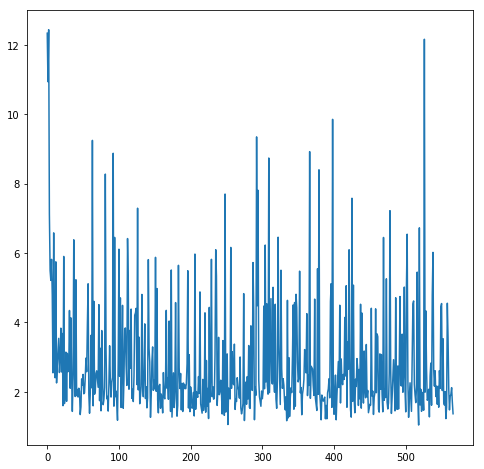

In [7]:
plt.figure(figsize=(8, 8))
plt.plot(losses)
plt.show(); plt.close()

In [8]:
print(_tys[0][0][0])

tensor([3.4952], device='cuda:1')


In [9]:
yt = tonpy(ytrue)
yp = tonpy(ypred)
print(yt.shape)

(32, 1, 11)


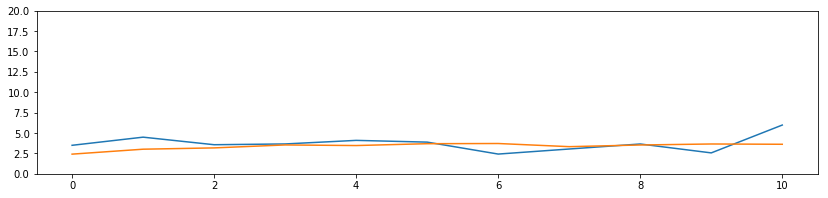

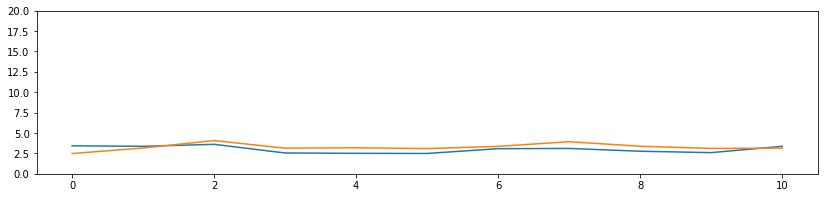

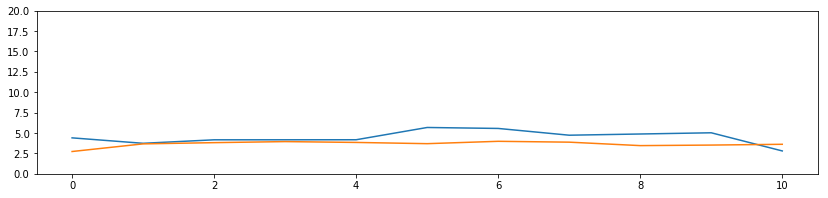

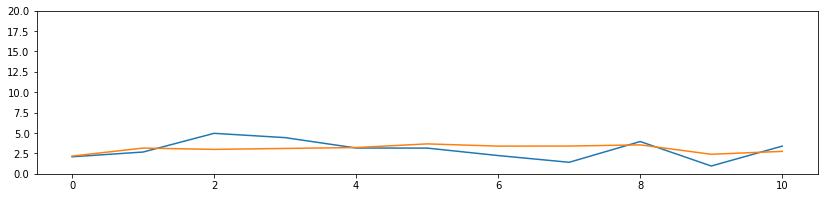

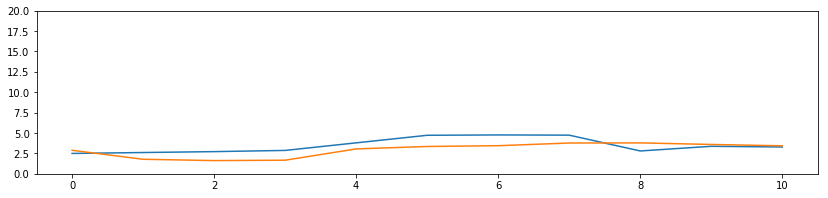

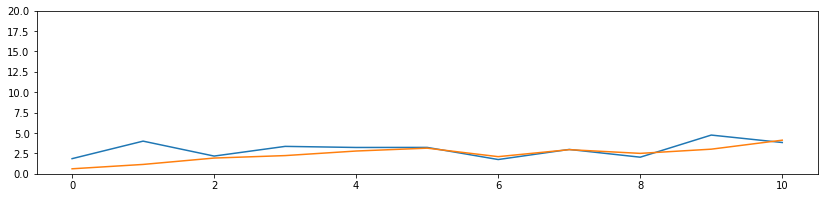

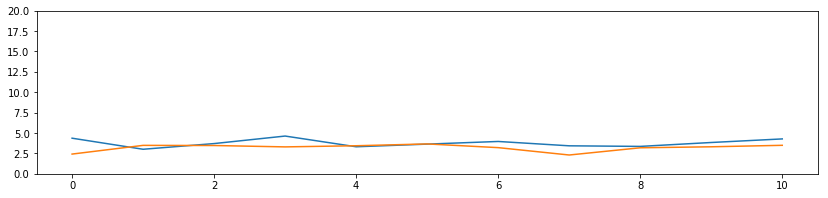

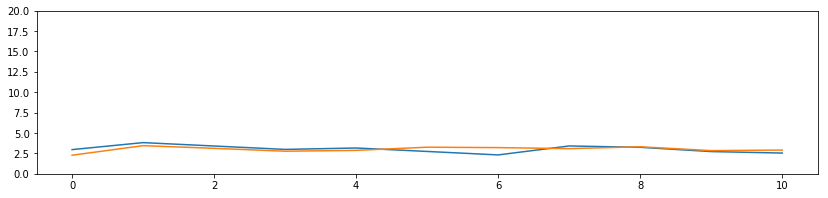

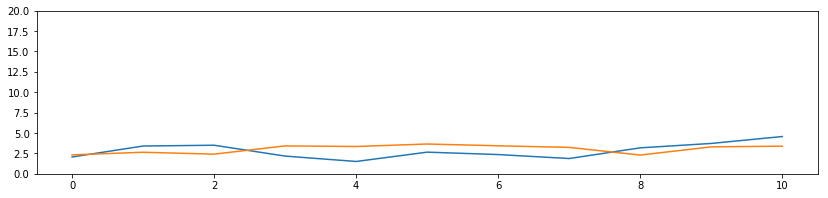

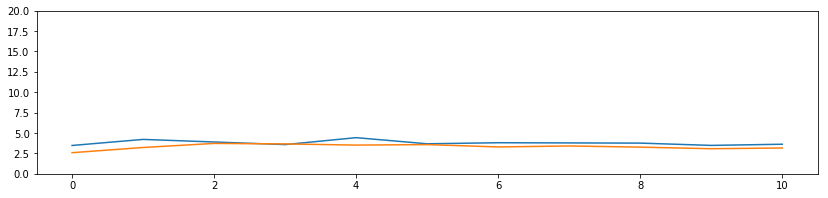

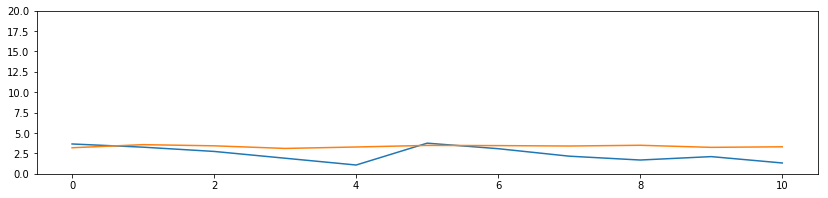

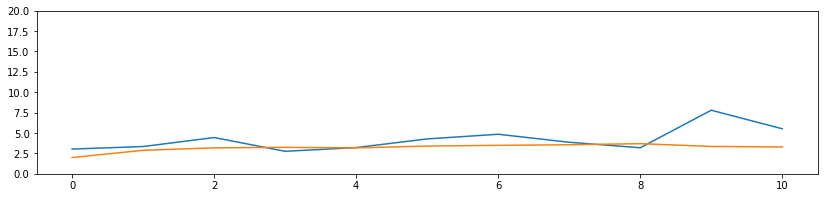

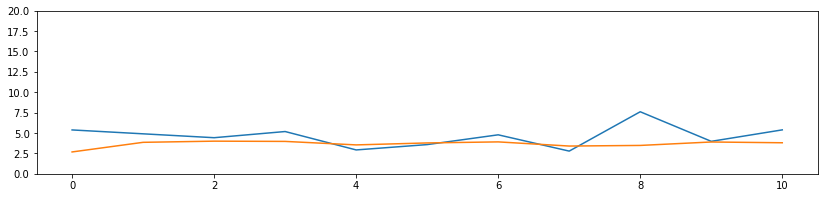

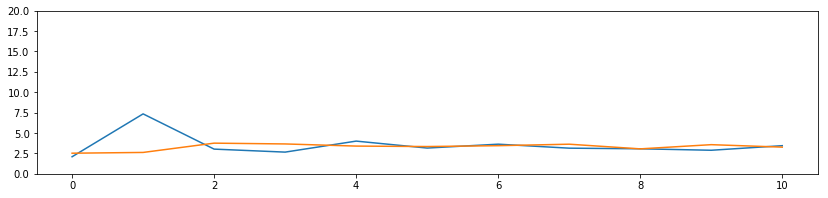

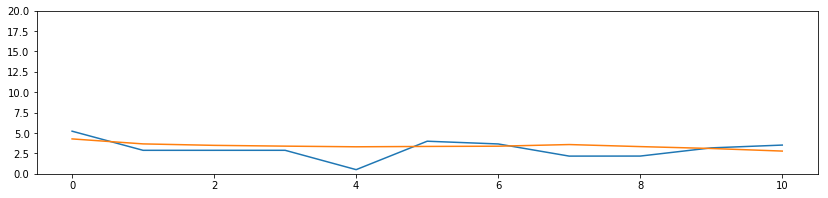

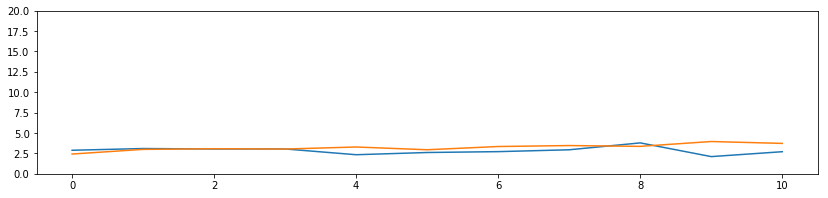

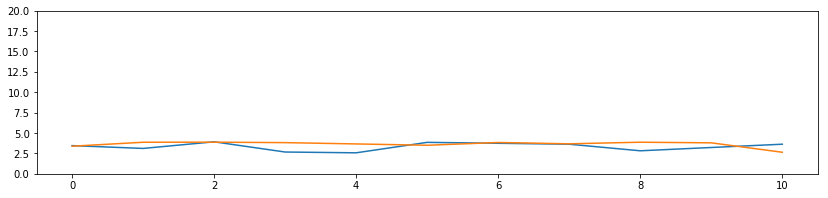

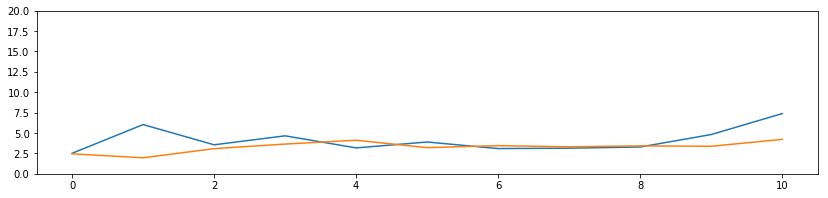

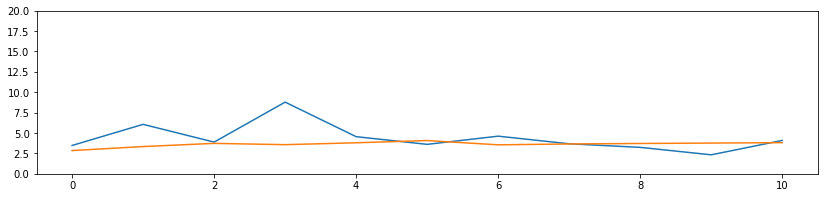

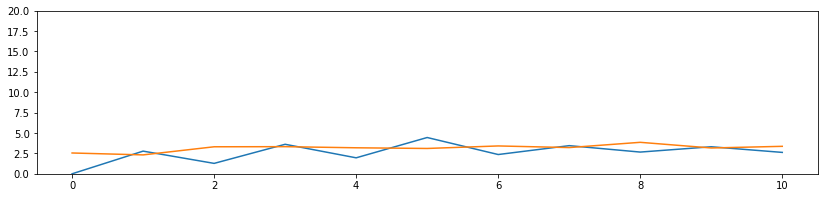

In [10]:
for bat in range(20):
    plt.figure(figsize=(14, 3))
    plt.plot(yt[bat][0])
    plt.plot(yp[bat][0])
    plt.ylim(0, 20)
    plt.show(); plt.close()